In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image, ImageOps

import os
import time

In [12]:
class MRLDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.transforms = transforms.Compose([transforms.Resize([24, 24]),
                                              transforms.ToTensor()]) 
        self.img_paths = []
        self.img_labels = []

        # Traverses all subfolders and stores the path and label of each training example
        subfolders = os.listdir(path)
        for folder in subfolders:
            p = os.path.join(path, folder)

            if os.path.isdir(p):                                                    # ignores documentation files
                imgs = os.listdir(p)

                for file_name in imgs:
                    self.img_paths.append(os.path.join(p, file_name))               # append image path
                    self.img_labels.append(int(file_name.split("_")[4]))            # append eye state label
    
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("L")
        img = self.transforms(img)
        label = self.img_labels[idx]

        return (img, label)


In [3]:
class EyeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Evaluates accuracy (and loss) based for DataLoader
def evaluate(model, loader, criterion = None):
    total_losses = 0
    total_correct = 0
    total_examples = 0

    for i, [inputs, labels] in enumerate(loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        
        # Track total loss
        if criterion:
            loss = criterion(outputs, labels)
            total_losses += loss.item()

        # Track total correct
        pred = outputs.argmax(dim = 1)
        total_correct += pred.eq(labels).sum().item()
        total_examples += inputs.shape[0]

    if criterion:
        return total_losses/(i+1), total_correct/total_examples 
    else:
        return total_correct/total_examples

# Predicts output based on a single 1x24x24 image tensor
def predict(model, img):
    outputs = model(img.unsqueeze(0))
    prob = F.softmax(outputs, dim = 1)
    pred = outputs.argmax(dim = 1).item()

    print(f"Probabilities: ({prob[0][0]}, {prob[0][1]})")
    print("Prediction:", pred)

In [5]:
def train(model, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    iters, train_losses, valid_losses, train_acc, valid_acc = [], [], [], [], []

    t = time.time()

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)                     # forward pass

            loss = criterion(outputs, labels)           # calculate loss
            loss.backward()                             # calculate gradients using backprop
            optimizer.step()                            # apply optimizer step
            optimizer.zero_grad()                       # zero the gradients

        # Calculate and record loss/accuracy values
        [l, a] = evaluate(model, train_loader, criterion)
        train_losses.append(l)
        train_acc.append(a)

        [l, a] = evaluate(model, valid_loader, criterion)
        valid_losses.append(l)
        valid_acc.append(a)

        iters.append(epoch)

        print("Epoch:", epoch, "Time Taken:", time.time() - t)
        t = time.time()

        
    # Plot training curves
    plt.title("Training Curve - Loss")
    plt.plot(iters, train_losses, label = "Training")
    plt.plot(iters, valid_losses, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(valid_losses[-1]))
    print()

    plt.title("Training Curve - Accuracy")
    plt.plot(iters, train_acc, label = "Training")
    plt.plot(iters, valid_acc, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

In [6]:
# Create Dataset object
dataset = MRLDataset("./Datasets/MRL")       # Pass in root folder of dataset

# Random split (60-20-20)
n = len(dataset)
n_train = int(0.7 *n)
n_valid = int(0.15 *n)
n_test = n - n_train - n_valid

[train_set, valid_set, test_set] = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

"""
# 10% of datasets
train_set = torch.utils.data.Subset(train_set, range(int(0.5 * len(train_set))))
valid_set = torch.utils.data.Subset(valid_set, range(int(0.5 * len(valid_set))))
test_set = torch.utils.data.Subset(test_set, range(int(0.5 * len(test_set))))
"""

# Create DataLoaders
batch_size = 32
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Epoch: 0 Time Taken: 72.12334275245667
Epoch: 1 Time Taken: 68.28418207168579
Epoch: 2 Time Taken: 68.00483918190002
Epoch: 3 Time Taken: 67.09201955795288
Epoch: 4 Time Taken: 71.38202738761902
Epoch: 5 Time Taken: 73.25348091125488
Epoch: 6 Time Taken: 67.48882460594177
Epoch: 7 Time Taken: 70.28859043121338
Epoch: 8 Time Taken: 67.43788456916809
Epoch: 9 Time Taken: 68.95002460479736
Epoch: 10 Time Taken: 70.48782444000244
Epoch: 11 Time Taken: 70.1263656616211
Epoch: 12 Time Taken: 69.34038925170898
Epoch: 13 Time Taken: 68.26120162010193
Epoch: 14 Time Taken: 65.64543795585632
Epoch: 15 Time Taken: 65.63101816177368
Epoch: 16 Time Taken: 67.42552328109741
Epoch: 17 Time Taken: 67.50480794906616
Epoch: 18 Time Taken: 68.88110017776489
Epoch: 19 Time Taken: 69.63994693756104


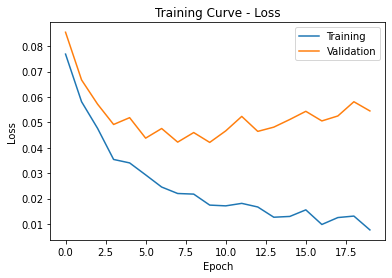

Final Training Loss: 0.007649422601009134
Final Validation Loss: 0.05449162497752815



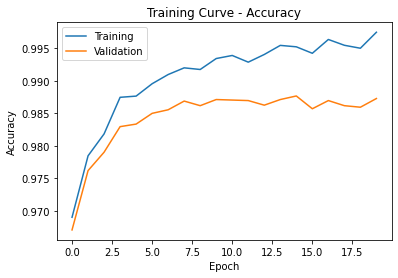

Final Training Accuracy: 0.9974591101837518
Final Validation Accuracy: 0.987278152976284


In [7]:
model = EyeClassifier()

train(model, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 20)

In [8]:
'torch.save(model.state_dict(), "./Saved Models/model3.pt")

In [7]:
model = EyeClassifier()
model.load_state_dict(torch.load("./Saved Models/model2.pt"))
model.eval()

EyeClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [9]:
evaluate(model, test_loader)

0.987751256281407

In [11]:
# Make predictions for all images within "Frames" folder

t = transforms.Compose([transforms.Resize([24, 24]), transforms.Grayscale(), transforms.ToTensor()]) 
frames_path = "./Frames"

for i, file_name in enumerate(os.listdir(frames_path)):
    img = Image.open(os.path.join(frames_path, file_name))
    img = t(img)

    print(f"\n{i}.jpg")
    predict(model, img)


715)
Prediction: 1

299.jpg
Probabilities: (6.372058578563156e-07, 0.9999994039535522)
Prediction: 1

300.jpg
Probabilities: (0.0005826512351632118, 0.9994174242019653)
Prediction: 1

301.jpg
Probabilities: (0.6618556976318359, 0.3381442725658417)
Prediction: 0

302.jpg
Probabilities: (0.2614472806453705, 0.7385526895523071)
Prediction: 1

303.jpg
Probabilities: (0.8774189949035645, 0.12258099764585495)
Prediction: 0

304.jpg
Probabilities: (0.9526641368865967, 0.04733588546514511)
Prediction: 0

305.jpg
Probabilities: (0.8289942145347595, 0.17100583016872406)
Prediction: 0

306.jpg
Probabilities: (0.012134953401982784, 0.9878650307655334)
Prediction: 1

307.jpg
Probabilities: (0.000352802308043465, 0.9996471405029297)
Prediction: 1

308.jpg
Probabilities: (0.00024786373251117766, 0.9997521042823792)
Prediction: 1

309.jpg
Probabilities: (2.0842486492256285e-07, 0.9999997615814209)
Prediction: 1

310.jpg
Probabilities: (3.800542458520795e-08, 1.0)
Prediction: 1

311.jpg
Probabilities: 

In [19]:
img = Image.open(os.path.join(frames_path, "216.jpg"))
img = t(img)

predict(model, img)

Probabilities: (0.999854564666748, 0.00014536091475747526)
Prediction: 0
